# Create Raster Dataset

### Import required packages.

In [1]:
# General imports:
import snowflake.connector
import xarray as xr 
import pandas as pd
import numpy as np
import geopandas as gpd
import yaml
import rioxarray as rxr
import os
from dotenv import load_dotenv

# Load environment variables.
load_dotenv()

True

### Connect to snowflake and pull variables of interest.
Note that the access credentials to the snowflake database are not included below. The code should be modified where shown to include the access credentials provided to you. 

In [2]:
# Pull database information from the config yaml file. 
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

# Define the SQL query to get ACD data from Planet for 2015-2020.
sql_query = """
    SELECT
        year,
        x,
        y,
        aboveground_live_carbon_density
    FROM
        planet.raw_forest_carbon_diligence_30_m
    WHERE
        year BETWEEN 2015 AND 2020
    """

# Connect to database and execute query.
with snowflake.connector.connect(
        account=os.getenv('DB_ACCOUNT'),
        warehouse=os.getenv('DB_WAREHOUSE'),
        database=os.getenv('DB_DATABASE'), 
        user=os.getenv('DB_USERNAME'),
        password=os.getenv('DB_PASSWORD')
) as conn:
    cur = conn.cursor().execute(sql_query)
    df = cur.fetch_pandas_all()

# Examine dataframe.
df.head(10)

,YEAR,X,Y,ABOVEGROUND_LIVE_CARBON_DENSITY
0,2017,-1.388625,53.747875,NaN
1,2019,-1.415625,53.749625,0.0
2,2019,-1.393625,53.746375,26.0
3,2018,-1.408875,53.754375,0.0
4,2019,-1.396375,53.752375,0.0
5,2016,-1.408875,53.754375,0.0
6,2019,-1.402125,53.752625,0.0
7,2019,-1.390125,53.750125,0.0
8,2017,-1.389625,53.748875,0.0
9,2020,-1.407125,53.742125,NaN


## Option 1: XArray and Rioxarray.
[XArray](https://docs.xarray.dev/en/stable/) is widely used for handling NetCDF data structures, but is also useful for working with multi-layered raster data. With the [rioxarray](https://corteva.github.io/rioxarray/stable/) extension, it is possible to read and write GeoTIFFs and perform geospatial operations within the XArray format.

In [5]:
# Ensure that the data types of the LAT, LON, and ACD columns are numeric.
df[['Y', 'X', 'ABOVEGROUND_LIVE_CARBON_DENSITY']] = df[['Y', 'X', 'ABOVEGROUND_LIVE_CARBON_DENSITY']].apply(pd.to_numeric, errors='coerce')

# Set dataframe indices before converting to xarray and renaming dimensions for use with rioxarray.
data_df = df.set_index(['YEAR','Y', 'X'])
data_xarr = data_df.to_xarray().rename({'Y': 'y', 'X': 'x', 'YEAR': 'time'})

# Assign WGS84 CRS (EPSG:4326)
data_xarr = data_xarr.rio.write_crs("EPSG:4326", inplace=True)

# Visualize the data structure as a xarray Dataset.
data_xarr


<xarray.Dataset> Size: 715kB
Dimensions:                          (time: 6, y: 83, x: 179)
Coordinates:
  * time                             (time) int16 12B 2015 2016 ... 2019 2020
  * y                                (y) float64 664B 53.74 53.74 ... 53.76
  * x                                (x) float64 1kB -1.428 -1.427 ... -1.383
    spatial_ref                      int64 8B 0
Data variables:
    ABOVEGROUND_LIVE_CARBON_DENSITY  (time, y, x) float64 713kB nan nan ... nan

### Export to GeoTIFF.

In [6]:
# Export multi-band raster (2015 - 2020).
data_xarr.ABOVEGROUND_LIVE_CARBON_DENSITY.rio.to_raster('outputs/planet-acd-2015-2020.tif')

# Export single-band raster (2020).
data_xarr.sel(time=[2020])['ABOVEGROUND_LIVE_CARBON_DENSITY'].rio.to_raster('outputs/planet-acd-2020.tif')

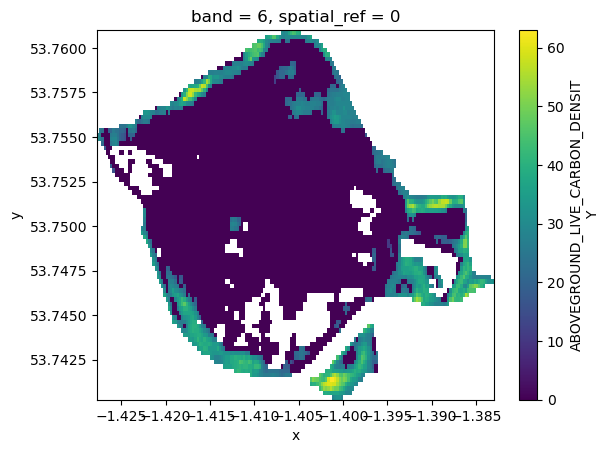

In [7]:
# Read the GeoTIFF back and try plotting one of the bands (referring to years by the band index).
test_rast = rxr.open_rasterio('outputs/planet-acd-2015-2020.tif')
test_rast.sel(band=6).plot()